#REGRESSION ANALYSIS ON TESLA STOCK PRICES

 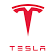

## IMPORTING REQUIRED PACKAGES & DATASET

We first import all the relevant packages that would be required for implementing the desired methods for regression.

In [ ]:
!pip install scikeras #to install the scikeras package

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
%matplotlib inline
import time
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from xgboost.plotting import plot_importance
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
import matplotlib.dates as mdates
from keras.optimizers import SGD, Adagrad, Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# set up the random number generator: given seed for reproducibility, None otherwise
# (see https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng)
my_seed = 1
rng = np.random.default_rng(seed=my_seed)

### **About the dataset:**

This dataset provides historical data from 2012 to 2022 of TESLA INC. stock (TSLA) in USD. The data is available at a daily level. The frequency of updation of the data is monthly. It has the following features:

**Date**: The date of the trading day.

**Open**: The opening price of the stock on that trading day.

**High**: The highest price the stock reached during that trading day.

**Low**: The lowest price the stock reached during that trading day.

**Close**: The closing price of the stock on that trading day.

**Adj Close**: The adjusted closing price, which accounts for any corporate actions such as stock splits, dividends, etc.

**Volume**: The trading volume, i.e., the number of shares traded during that trading day.

 **Aim**: We will try and predict the adjusted close prices using all of the relevant features using different methods of regression. Then, we would perform a comparative analysis of each method and provide a final verdict as to which method(s) suits this dataset the best to predict future adjusted close prices.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving TSLA.csv to TSLA.csv


##EXPLORATORY DATA ANALYSIS

Next, we perform some Exploratory Data Analysis on the dataset where we plot graphs and check for redundant features or multicollinearity.

In [ ]:
df = pd.read_csv('TSLA.csv')#reads the datafile
df.info()#providessome basic information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   Open       2956 non-null   float64
 2   High       2956 non-null   float64
 3   Low        2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Adj Close  2956 non-null   float64
 6   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.8+ KB


In [ ]:
print(df.shape)#gives us the shape of the dataset, number of samples x number of features

(2956, 7)


In [ ]:
df.head()#prints the initial few values of the dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [ ]:
df.describe()#provides statsitics regarding the features in the datatset based on the samples

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


**Observations:**

**1) Open, High, Low, Close, and Adj Close Prices:**
The mean values for these prices indicate that the stock tends to have a high average price, with the Close and Adj Close prices being very close.
The standard deviation values suggest that there is a considerable amount of variability or volatility in these prices, as the standard deviations are quite large compared to the mean values.

**2) Volume:**
The mean volume indicates the average number of shares traded, which is relatively high, suggesting that there is significant trading activity for this stock.
The standard deviation of volume suggests that the trading volume can vary considerably from day to day.

**3) Minimum and Maximum Values:**
The minimum and maximum values show the range within which the prices and volume have fluctuated over the given period.
The minimum values provide insights into the lowest prices and volumes observed, while the maximum values indicate the highest prices and volumes observed.

**4) Percentiles (25th, 50th, and 75th):**
These percentiles provide information about the distribution of prices and volume.
For example, the 25th percentile (also known as the first quartile) represents the value below which 25% of the data falls.
Similarly, the 50th percentile (median) represents the value below which 50% of the data falls, and the 75th percentile (third quartile) represents the value below which 75% of the data falls.

We index the dataset using the 'Date' column. The information that would be required from this column for regression purposed are the months and the year of the datapoint, which will be extracted and encoded.

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])#Convert the 'Date' column into an index
# Set 'Date' as the index
df.set_index('Date', inplace=True)

In [ ]:
df['year'] = df.index.year#extract the year and add an additional feature to the dataset
df['month'] = df.index.month#extract the month and add an additional feature to the dataset

We use label encoding to enclode the year feature, since they are ordinal in nature and more recent years would play a comparitively higher role in predicting the values of the target feature which is the adjusted close feature in our case.

In [ ]:
label_encoder = LabelEncoder()
df['year'] = label_encoder.fit_transform(df['year'])#usinglabel encoder to enclode the years for easier interpretability

### Data Visualisation

Next, we plot a few graphs to visualise the data helping us to interpret the data better.

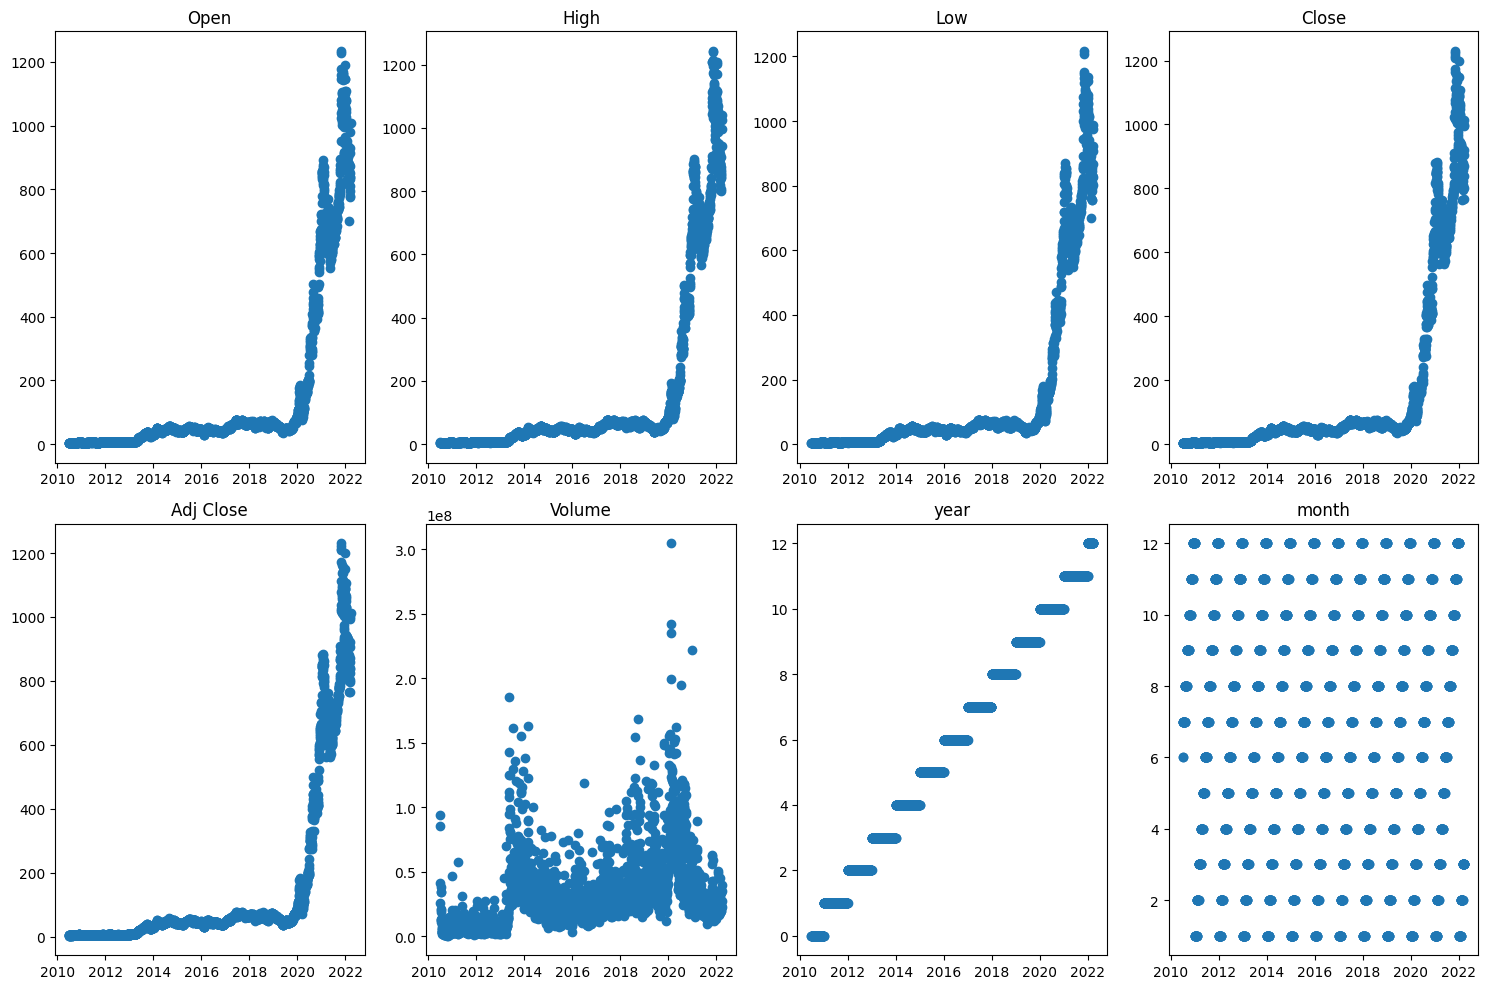

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
# Enumerate over all columns
for idx, feature in enumerate(df.columns):
    x = df.index  # Extracting the datetime index as x-values
    y = df[feature]  # Selecting the column values as y-values
    axes[idx // 4, idx % 4].scatter(x, y)  # Plotting scatter plot
    axes[idx // 4, idx % 4].set_title(feature)  # Setting title for each subplot
plt.tight_layout()  # Adjusting layout
plt.show()

**Observations:**

**1) Similarity in Open, High, Low, Close, and Adj Close vs Adj Close:**
The plots for Open, High, Low, Close, and Adj Close appear to be very similar, which is expected as these variables are typically highly correlated in stock market data. This similarity suggests that the price movements for these variables are closely related over time.

**2) Relationship between volume and adjusted close prices:**
The plot for the Volume feature shows some variability over time, with certain periods of higher trading volume and others of lower volume. This variability indicates fluctuations in trading activity in the market.
Additionally, there seems to be a positive correlation between Volume and time, as the volume tends to increase over the years. This suggests that trading activity has generally increased over time.

**3) Relationship between year and adjusted close prices:**
The observation of a clear positive correlation with the Year feature confirms the previous point about increasing trading activity over the years. This indicates a potential long-term trend in the market.
The positive correlation with the Year feature suggests that there may be some underlying factors or trends driving the increase in trading activity over time.

**4) Relationship between month and adjusted close prices:**

We cannot derive a proper explaination from this graph regarding the relationship between the month and the adjusted close prices. However, the thickness of the data points do indicate that there has been a rise in the prices but again that is not too clear.

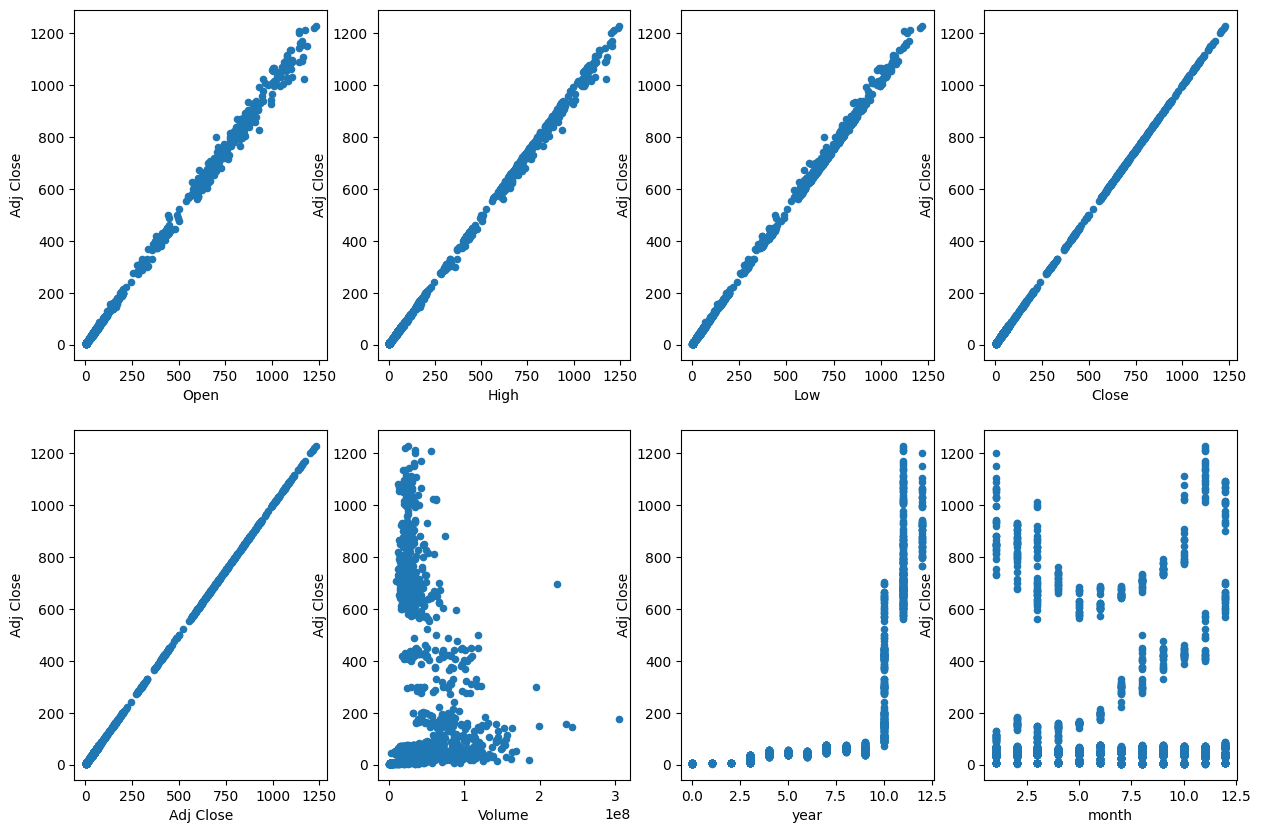

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
# position in the axes: vector [i,j] with i is the line number, and j the column index
for idx, feature in enumerate(df.columns):
    df.plot(feature, "Adj Close", subplots=True,  kind="scatter", ax=axes[idx // 4, idx % 4])
plt.show()

**Observations:**

**1) Linear Relationship between Open, High, Low, Close, and Adj Close:**
There appears to be a linear relationship between the Open, High, Low, Close, and Adj Close prices. This linear relationship is expected.

**2) Volume and adjusted close Price Relationship:**
There seems to be an inverse relationship between the volume traded and the price of the shares. As the price of the shares increases, the volume traded tends to decrease, and vice versa. This observation is consistent with typical market behavior, where higher prices may lead to decreased trading activity and vice versa.

**3) Year and adjusted close price relationship:**
The values of the Adj Close price seem to be increasing over the years, with a noticeable spike in the last two years. This suggests a potential trend of increasing minimum prices over time, indicating overall growth or inflation in stock prices.

**4) Month and adjusted close Price Relationship:**
There appears to be an upward trend in the Adj Close prices with changes in months across different years. This suggests that there may be seasonal trends or patterns in stock prices, with certain months exhibiting higher prices compared to others.

Next we plot the trend of the Open, High, Close, Adj Close and Volume with respect to time

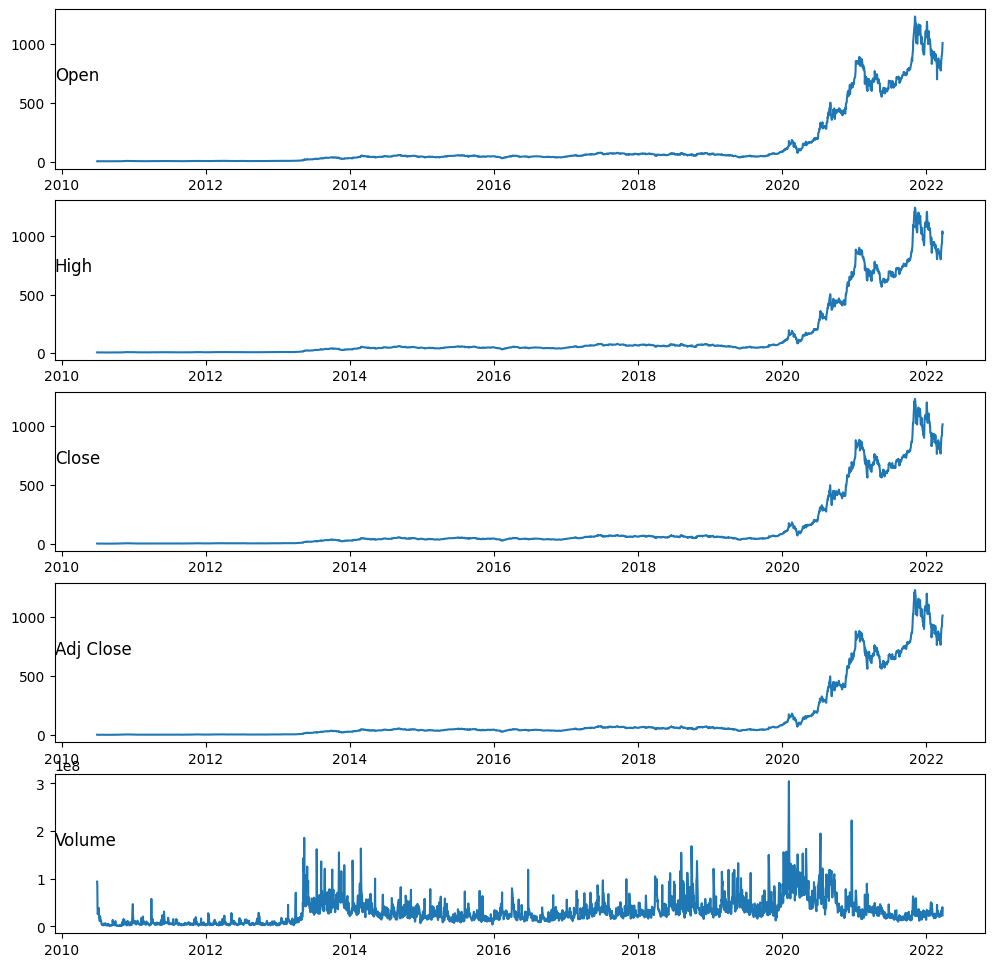

In [ ]:
plt.figure(figsize=(12, 12))

columns = [str(c) for c in df[['Open','High','Close','Adj Close','Volume']]]#declaring the columns to be used for the subplot

for i, c in enumerate(columns):
    plt.subplot(len(columns), 1, i+1)
    plt.plot(df[c])
    plt.title(c, y=0.5, loc='left')

plt.show()

There seems to be very little increase in the values of the prices, other than volume which has a few spikes in between, till the year 2020, after which there is a significant rise in the share prices. This can possibly be related due to trends related to the company during recent years because of which there might have been some exceptional engagement. It can also be attributed to the COVID-19 pandemic.

We plot all the prices to observe how closely they are related

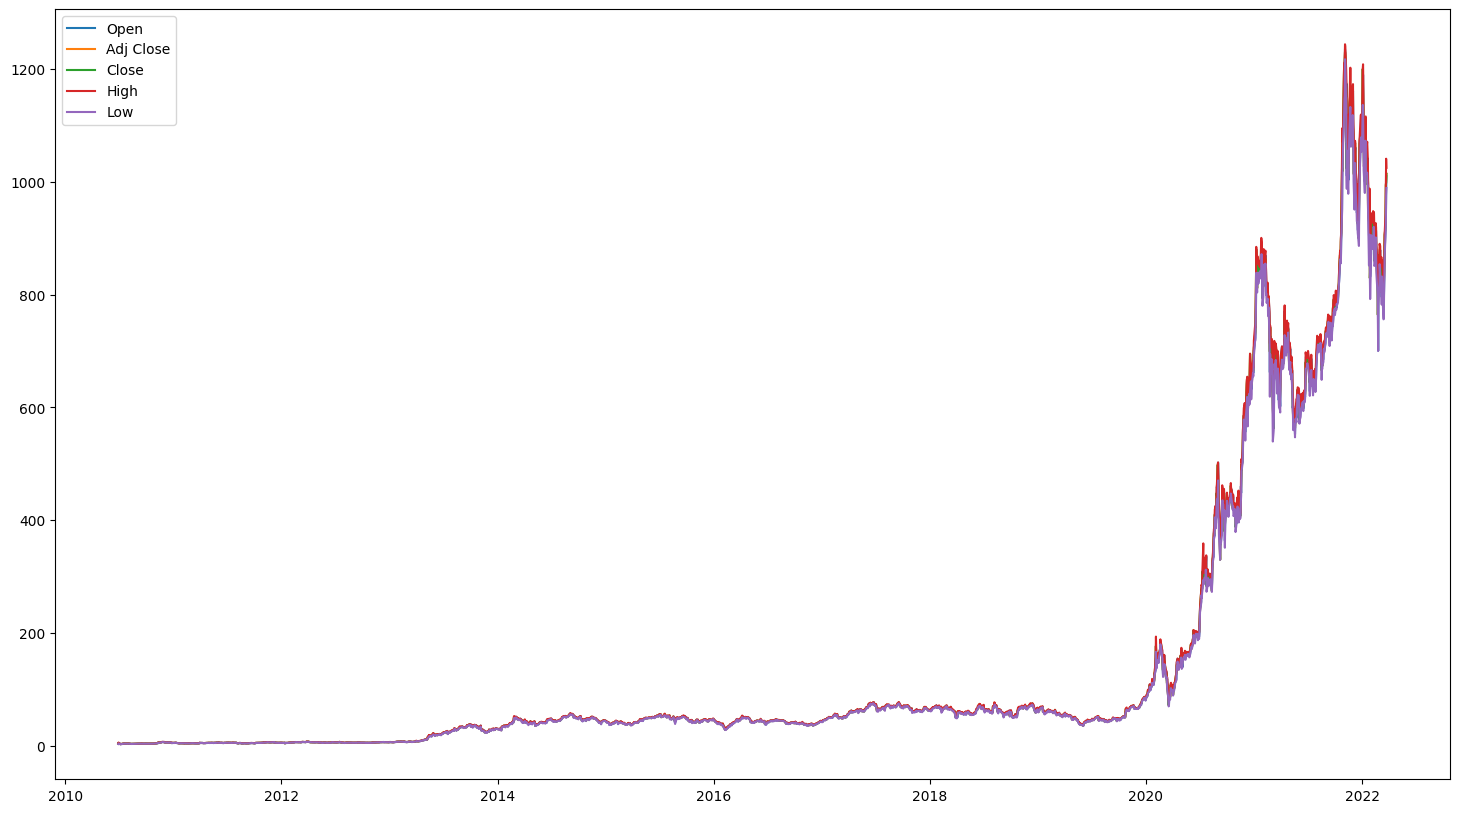

In [ ]:
plt.figure(figsize = (18,10))
plt.plot(df['Open'])
plt.plot(df['Adj Close'])
plt.plot(df['Close'])
plt.plot(df['High'])
plt.plot(df['Low'])
plt.legend(['Open','Adj Close','Close','High','Low'])

This graph again confirms the high correlation that is present between all of the price features in the dataset which is a trademark for almost all relevant stocks in the share market.

We will drop the 'Close' column, since it is unnecessary to compare it with the adjusted closing prices.

In [ ]:
df.drop('Close',axis=1,inplace=True)

We create additional columns in plot_df(copy of df) to extract various time-related features from the index of the dataset. These features include:

* **weekday_name:** Name of the weekday (e.g., Monday, Tuesday).

* **weekday:** Numeric representation of the weekday (0 for Monday, 1 for Tuesday, and so on).

* **week:** Week number of the year.

* **day:** Day of the month.

* **hour:** Hour of the day
.
* **date:** Date component of the index.

* **month:** Month number.
* **month_name:** Name of the month (e.g., January, February).

* **year:** Year component of the index.

We convert the month_name and weekday_name columns to ordered categoricals to ensure that they are sorted correctly in plots.

In [ ]:
#create a copy of dataset, then define indices
plot_df = df.copy()
plot_df["weekday_name"] = plot_df.index.day_name()
plot_df["weekday"] = plot_df.index.weekday
plot_df["week"] = plot_df.index.isocalendar().week
plot_df["day"] = plot_df.index.day
plot_df["hour"] = plot_df.index.hour
plot_df["date"] = plot_df.index.date
plot_df["month"] = plot_df.index.month
plot_df["month_name"] = plot_df.index.month_name()
plot_df["year"] = plot_df.index.year
#Although many of these are not features of the index columns 'Date', I still declare them for flexibility in future analysis, in case the dataset gets updated.
#Making ordered categoricals to make for sorted plots
plot_df['month_name'] = pd.Categorical(plot_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
plot_df['weekday_name'] = pd.Categorical(plot_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)

We group plot_df by year and month_name, calculate the mean of the 'Adj Close' prices for each group, drop any missing values, and reset the index. The resulting DataFrame plot_df_monthly contains the average 'Adj Close' prices for each month across different years.

In [ ]:
plot_df_monthly = plot_df[plot_df.year.isin([2016, 2017,2018, 2019, 2020, 2021, 2022])].groupby(['year', 'month_name'])['Adj Close'].mean().dropna().reset_index()
plot_df_monthly

,year,month_name,Adj Close
0,2016,January,40.912421
1,2016,February,33.934000
2,2016,March,43.229454
3,2016,April,50.191810
4,2016,May,43.326762
...,...,...,...
70,2021,November,1120.662383
71,2021,December,1018.889990
72,2022,January,1010.168497
73,2022,February,878.884737


In [ ]:
fig = px.line(plot_df_monthly, x="month_name", y='Adj Close', color="year", title="Yearwise Monthly Plot")
fig.show()

Below, I have also plotted the Pearson heatmap to confirm the correlation between the features

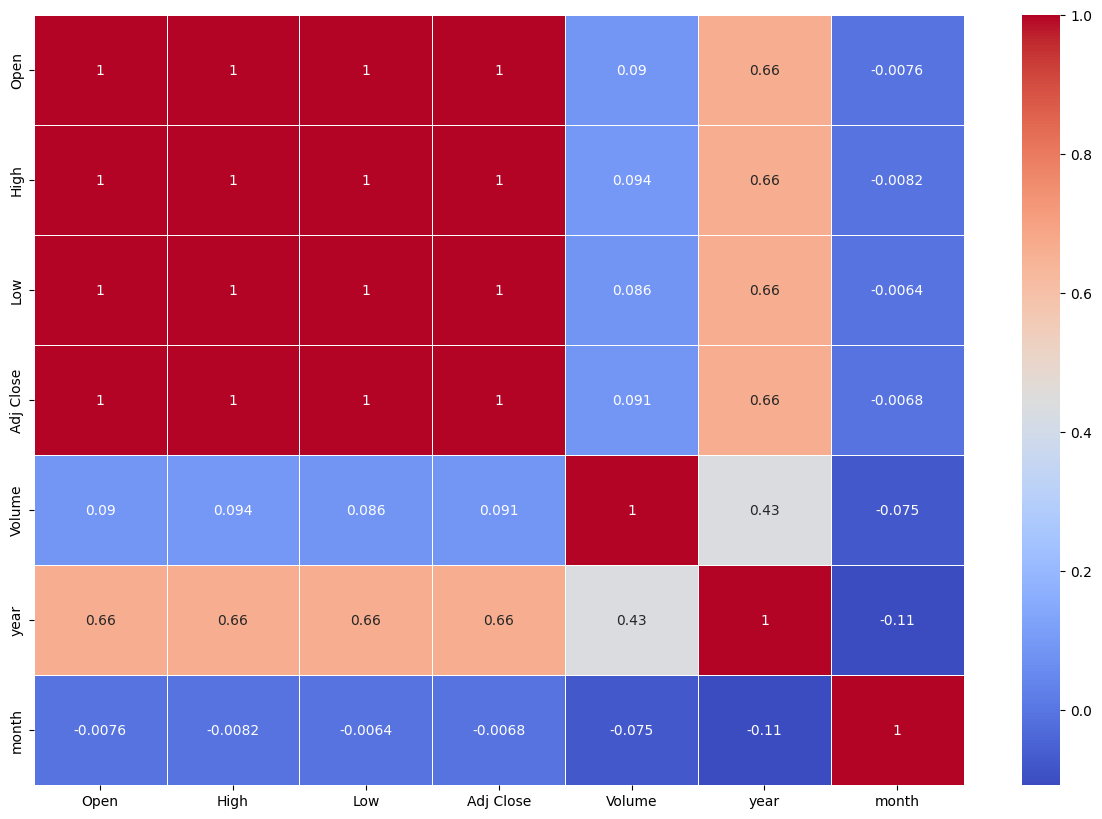

In [ ]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(method='pearson'), annot = True, linewidths=.5, cmap="coolwarm")
plt.show()

Thus we can now confirm the high correlation between the 'Open', 'High', 'Low' and 'Adj Close' prices. They year also has a large positive correlation with the other features except the months, which is the only feature with negative correlations with all of the other features.

##NORMALISATION OF DATA

Now we split the data into testing and training sets in a 70:30 ratio

In [ ]:
fraction_train = 0.7
fraction_test = 1.0 - fraction_train
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2069 entries, 2015-04-08 to 2012-09-19
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2069 non-null   float64
 1   High       2069 non-null   float64
 2   Low        2069 non-null   float64
 3   Adj Close  2069 non-null   float64
 4   Volume     2069 non-null   int64  
 5   year       2069 non-null   int64  
 6   month      2069 non-null   int32  
dtypes: float64(4), int32(1), int64(2)
memory usage: 121.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 887 entries, 2015-06-12 to 2021-02-19
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       887 non-null    float64
 1   High       887 non-null    float64
 2   Low        887 non-null    float64
 3   Adj Close  887 non-null    float64
 4   Volume     887 non-null    int64  
 5   year       887 non-null    int64  
 6   month 

Using MinMaxScalar, we can normalize the training data

In [ ]:
scaler = MinMaxScaler()
df_train[:] = scaler.fit_transform(df_train[:])
df_train.describe()

,Open,High,Low,Adj Close,Volume,year,month
count,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000
mean,0.107909,0.109729,0.107165,0.108717,0.099471,0.487272,0.504108
std,0.201158,0.204881,0.199262,0.202637,0.090683,0.285762,0.316659
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.012379,0.013061,0.012133,0.012519,0.040220,0.250000,0.181818
50%,0.035218,0.035529,0.035278,0.035416,0.079665,0.500000,0.545455
75%,0.052287,0.052830,0.052260,0.052615,0.127051,0.750000,0.818182
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We print the minimum and maximum values to make sure that the normalization takes place properly

In [ ]:
min_values = df_train.min()
max_values = df_train.max()

print("Minimum values of features in the test data:")
print(min_values)

print("\nMaximum values of features in the test data:")
print(max_values)

Minimum values of features in the test data:
Open         0.0
High         0.0
Low          0.0
Adj Close    0.0
Volume       0.0
year         0.0
month        0.0
dtype: float64

Maximum values of features in the test data:
Open         1.0
High         1.0
Low          1.0
Adj Close    1.0
Volume       1.0
year         1.0
month        1.0
dtype: float64


Similarly, we perform the same commands for the testing data

In [ ]:
df_test[:] = scaler.transform(df_test[:])
df_test.describe()

,Open,High,Low,Adj Close,Volume,year,month
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000
mean,0.114842,0.116081,0.113565,0.114785,0.103542,0.489384,0.515527
std,0.207600,0.209668,0.204391,0.206840,0.095171,0.280671,0.307028
min,-0.000042,0.000144,0.000097,0.000261,-0.000370,0.000000,0.000000
25%,0.014659,0.015138,0.014543,0.015081,0.042465,0.250000,0.272727
50%,0.035249,0.035628,0.035203,0.035321,0.079353,0.500000,0.545455
75%,0.053723,0.054353,0.053968,0.053907,0.132099,0.750000,0.818182
max,0.994793,0.997081,0.992587,0.993625,0.728386,1.000000,1.000000


In [ ]:
min_values = df_test.min()
max_values = df_test.max()

print("Minimum values of features in the test data:")
print(min_values)

print("\nMaximum values of features in the test data:")
print(max_values)

Minimum values of features in the test data:
Open        -0.000042
High         0.000144
Low          0.000097
Adj Close    0.000261
Volume      -0.000370
year         0.000000
month        0.000000
dtype: float64

Maximum values of features in the test data:
Open         0.994793
High         0.997081
Low          0.992587
Adj Close    0.993625
Volume       0.728386
year         1.000000
month        1.000000
dtype: float64


We can see that there are features which are not in the range $[0,1]$. This is because we are transforming the test data based on the fitting which was done on the training data.

##SIMPLE LINEAR REGRESSION

Now, we define the columns on which we want to perform linear regression. Here, I have compared the performance between the correlated features by training the model based on volume,month and year along with each one of the correlated features individually.

In [ ]:
feature_list = ['Open','High','Low']

for f in feature_list:
  print("Training based on features",f,",Volume,month and year")
  X1 = df_train[[f,'Volume','year','month']]
  y1 = df_train['Adj Close']
  X2 = df_test[[f,'Volume','year','month']]
  y2 = df_test['Adj Close']
  # build a model
  st = time.time()
  linear_regressor = linear_model.LinearRegression()
  linear_regressor.fit(X1, y1)
  et=time.time()
  print("Time to fit: ",(et-st),"s")
  y_pred=linear_regressor.predict(X2)
  # Model evaluation
  mse = mean_squared_error(y2, y_pred)
  r2 = r2_score(y2, y_pred)
  print("Mean Squared Error:", mse)
  print("R-squared:", r2)

Training based on features Open ,Volume,month and year
Time to fit:  0.021529436111450195 s
Mean Squared Error: 7.692328804220601e-05
R-squared: 0.9983032241904921
Training based on features High ,Volume,month and year
Time to fit:  0.0038154125213623047 s
Mean Squared Error: 3.336796241383037e-05
R-squared: 0.9992639686514012
Training based on features Low ,Volume,month and year
Time to fit:  0.00499415397644043 s
Mean Squared Error: 3.185353841721315e-05
R-squared: 0.9992973738537554


From the above results we can see that when we train based on the features low, volume, month and year, we seem to get the best result. This seems to be the case after a few re-runs.

##RIDGE AND LASSO REGRESSION

###Lasso Regression

In [ ]:
al = 0.0001# We consider some initial regularization

#We will be training based on all the features irrespective of high correlation, as lasso would deal with it by either minimizing or completely dropping the coefficient
X1 = df_train[['High','Low','Open','Volume','month','year']]
y1 = df_train['Adj Close']
X2 = df_test[['High','Low','Open','Volume','month','year']]
y2 = df_test['Adj Close']

st = time.time()
lasso = Lasso(alpha=al,max_iter=10000)
lasso.fit(X1, y1)
et=time.time()
print("Time to fit: ",(et-st),"s")

# Report coefficients
print('Intercept:', lasso.intercept_)
print('Rounded coef:', list(map(lambda c: round(c, 3), lasso.coef_)))
print('\nR2  (train) = ',lasso.score(X1,y1))
y_pred_train = lasso.predict(X2)

MSE = mean_squared_error(y2, y_pred_train)
print('MSE (train) = ',MSE)

Time to fit:  0.025899171829223633 s
Intercept: 0.00032264507373816476
Rounded coef: [0.64, 0.355, 0.0, -0.0, 0.0, 0.0]

R2  (train) =  0.9995493730462999
MSE (train) =  2.5267198209180867e-05


We can observe that Lasso has a realtively lower coefficient as compared to simple linear regression. However this is the case where we take an arbitrary regularization. We will perform some cross validation to help us get better results.

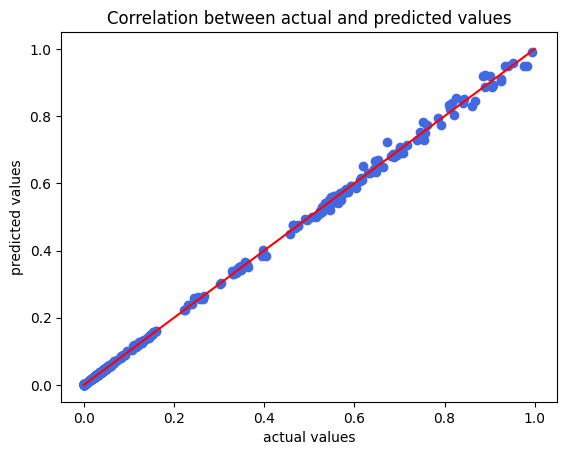

In [ ]:
# plotting the results
plt.title('Correlation between actual and predicted values')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.scatter(y2,y_pred_train,color='royalblue')
plt.plot([0,1],[0,1],color='red')
plt.show()

We can compute the average $R^{2}$ score and $MSE$ over the arbitrarily chosen $\alpha$ value

In [ ]:
al = 0.0001
nb_real = 100
#define lists to store R^2 and MSE
R2_test = np.zeros(nb_real)
MSE_test = np.zeros(nb_real)

lasso = Lasso(alpha = al,max_iter=10000)
for real in range(nb_real):#run a for loop in given range to get as many test-train splits
  df_train1, df_test1 = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
  df_train1[:] = scaler.fit_transform(df_train1[:])
  X_train = df_train1[['Open','High','Low','Volume','month','year']]
  y_train = df_train1['Adj Close']
  lasso.fit(X_train, y_train)
  df_test1[:] = scaler.transform(df_test1[:])
  X_test = df_test1[['Open','High','Low','Volume','month','year']]
  y_test = df_test1['Adj Close']
  R2_test[real] = lasso.score(X_test,y_test)
  MSE_test[real] = mean_squared_error(y_test, lasso.predict(X_test))

print('Average R2  (test) =', R2_test.mean())
print('Average MSE (test) =', MSE_test.mean())

Average R2  (test) = 0.9994779569860174
Average MSE (test) = 2.16647777618836e-05


We make note again that the scores are relatively better as compared to simple linear regression.

Next, we perform some cross validation on the $\alpha$ values to check for the best regularizator value. We also proceed to note the coefficients related to each feature, indicating the feature importance according to LASSO regression.

In [ ]:
df_train2, df_test2 = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train2[:] = scaler.fit_transform(df_train2[:])
X_train = df_train2[['Open','High','Low','Volume','year','month']]
y_train = df_train2['Adj Close']

alphas_lasso = np.logspace(-7, -3, 500)
nb_folds = 10
reg = LassoCV(cv=nb_folds, alphas = alphas_lasso,max_iter = 10000)
st = time.time()
reg.fit(X_train, y_train)
et=time.time()
print("Time to fit: ",(et-st),"s")
print('Regularizator score (R2 coefficient):', reg.score(X_train, y_train))
y_train_pred = reg.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print('Mean Squared Error (MSE):', mse_train)
print('Regularizator\'s optimal alpha value:', reg.alpha_)
print('Regularizator coefficients:')
[(pair[0], round(pair[1], 4)) for pair in zip(X_train, reg.coef_)]

Time to fit:  1.180248737335205 s
Regularizator score (R2 coefficient): 0.9997460649777825
Mean Squared Error (MSE): 1.0579850800324728e-05
Regularizator's optimal alpha value: 1e-07
Regularizator coefficients:


[('Open', -0.681),
 ('High', 0.9322),
 ('Low', 0.7462),
 ('Volume', 0.0006),
 ('year', 0.0),
 ('month', 0.0005)]

**Observations:**

**1)**The Lasso regression model demonstrates a high level of predictive accuracy, as indicated by the R2 coefficient of 0.9997.

**2)**The optimal alpha value, chosen to balance between model complexity and performance, is 1e-07.

**3)**Notably, the coefficients for 'Open', 'High', and 'Low' exhibit strong correlations with the target variable 'Adj Close', as evidenced by their magnitudes and signs.

**4)**'Volume' does not contribute significantly to the model, as its coefficient is effectively reduced to zero due to Lasso's regularization effect.
The coefficients for 'year' and 'month' are minimal, suggesting limited influence on the target variable compared to the price-related features.\

**5)** $MSE$ is low compared to simple linear regression.

Overall, despite the high collinearity among 'Open', 'High', and 'Low', Lasso regression effectively selects and prioritizes these features for prediction, while disregarding the less impactful 'Volume', 'year', and 'month' variables.

We plot the graph of the mean squared error values versus the $\alpha$ values

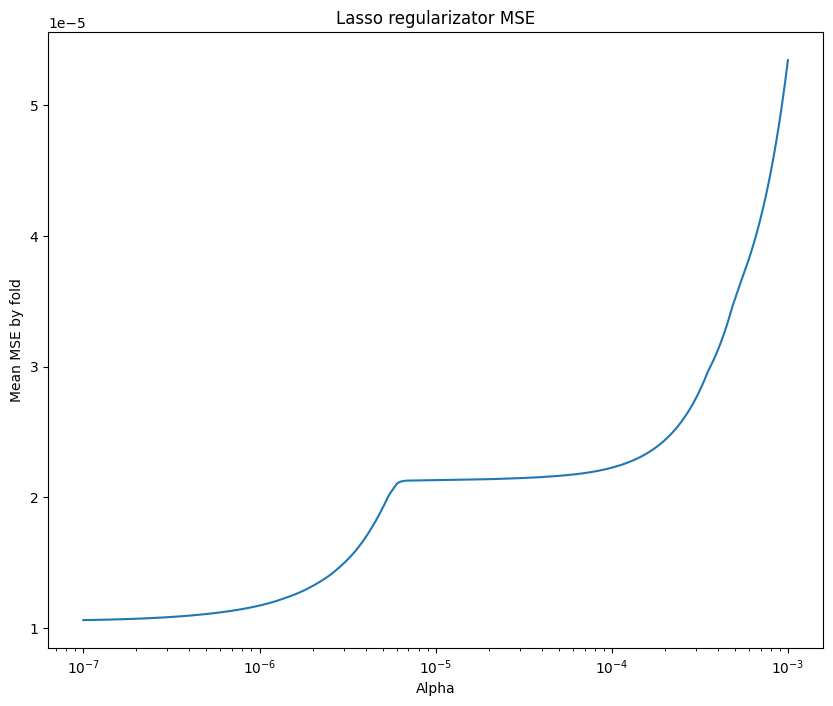

In [ ]:
mean_mse_arr = np.array(reg.mse_path_).mean(axis=1)
plt.figure(figsize=(10, 8))
plt.semilogx(reg.alphas_, mean_mse_arr, label=feature )
plt.xlabel("Alpha")
plt.ylabel("Mean MSE by fold")
plt.title("Lasso regularizator MSE")
plt.show()

There seems to be an increase in the MSE with increase in alpha values, indicating that there is very little regularization that is required.

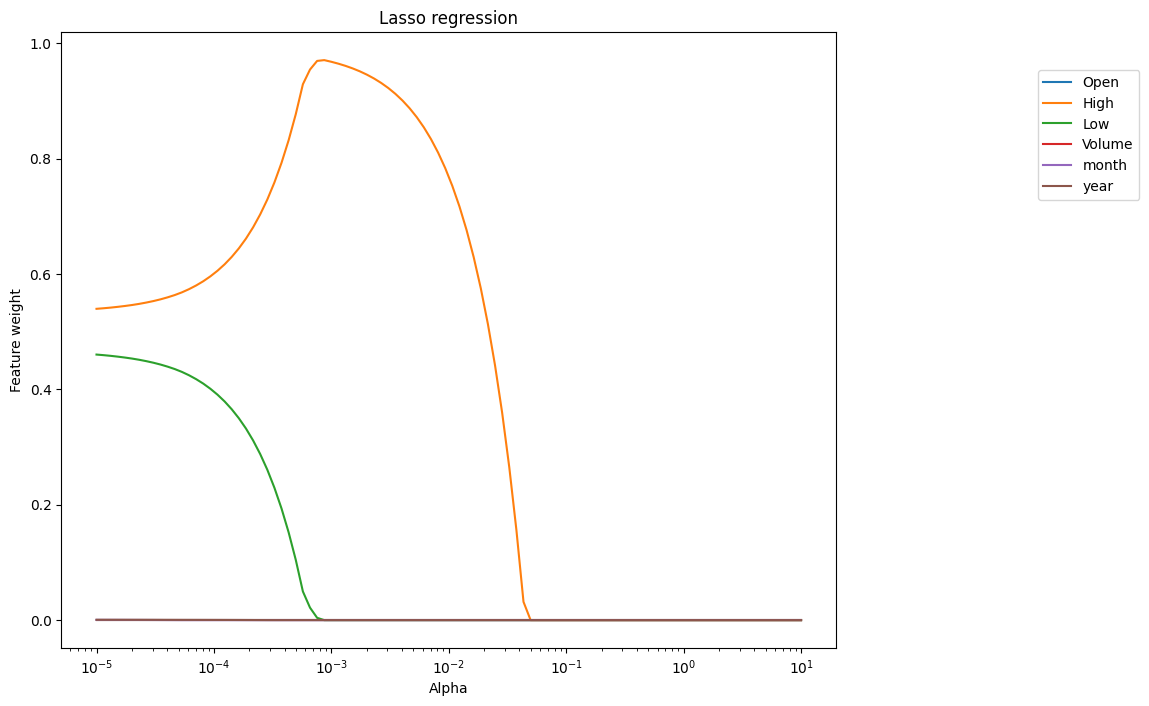

In [ ]:
# we use coefficients logarithmically spaced in order to cover a wide range of values
alphas_lasso = np.logspace(-5, 1, 100)
coefs_lasso = np.zeros((alphas_lasso.shape[0], X_train.shape[1]))

for i, al in enumerate(alphas_lasso):
    lasso = Lasso(alpha = al,max_iter=10000)
    lasso.fit(X_train, y_train)
    for j, coef in enumerate(lasso.coef_):
        coefs_lasso[i][j] = coef

plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_lasso.T, X_train.columns):
    plt.semilogx(alphas_lasso, coef, label=feature)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("Alpha")
plt.ylabel("Feature weight")
plt.title("Lasso regression")
plt.show()

One can notice that the Open feature seems to vanish. This is the case since LASSO decided with the chang over alphas to do so because of the high correlation between the features High, Low and Open. Volume, month and year also have very little impact. We can print the coefficients to verify our claim.

In [ ]:
coefs_lasso

array([[-0.00000000e+00,  5.39558058e-01,  4.60260831e-01,
         0.00000000e+00,  4.07206634e-04,  5.81489119e-04],
       [-0.00000000e+00,  5.40533896e-01,  4.59233100e-01,
         0.00000000e+00,  3.92546169e-04,  5.75691582e-04],
       [-0.00000000e+00,  5.41672375e-01,  4.58034574e-01,
         0.00000000e+00,  3.75713029e-04,  5.69030234e-04],
       [-0.00000000e+00,  5.42996343e-01,  4.56641220e-01,
         0.00000000e+00,  3.56379753e-04,  5.61375310e-04],
       [ 0.00000000e+00,  5.44480751e-01,  4.55077909e-01,
         0.00000000e+00,  3.34098841e-04,  5.52563897e-04],
       [ 0.00000000e+00,  5.46160539e-01,  4.53308023e-01,
         0.00000000e+00,  3.08443963e-04,  5.42425719e-04],
       [ 0.00000000e+00,  5.48135171e-01,  4.51228801e-01,
         0.00000000e+00,  2.79006971e-04,  5.30780844e-04],
       [ 0.00000000e+00,  5.50420389e-01,  4.48822987e-01,
         0.00000000e+00,  2.45182155e-04,  5.17396042e-04],
       [ 0.00000000e+00,  5.53007618e-01,  4.460

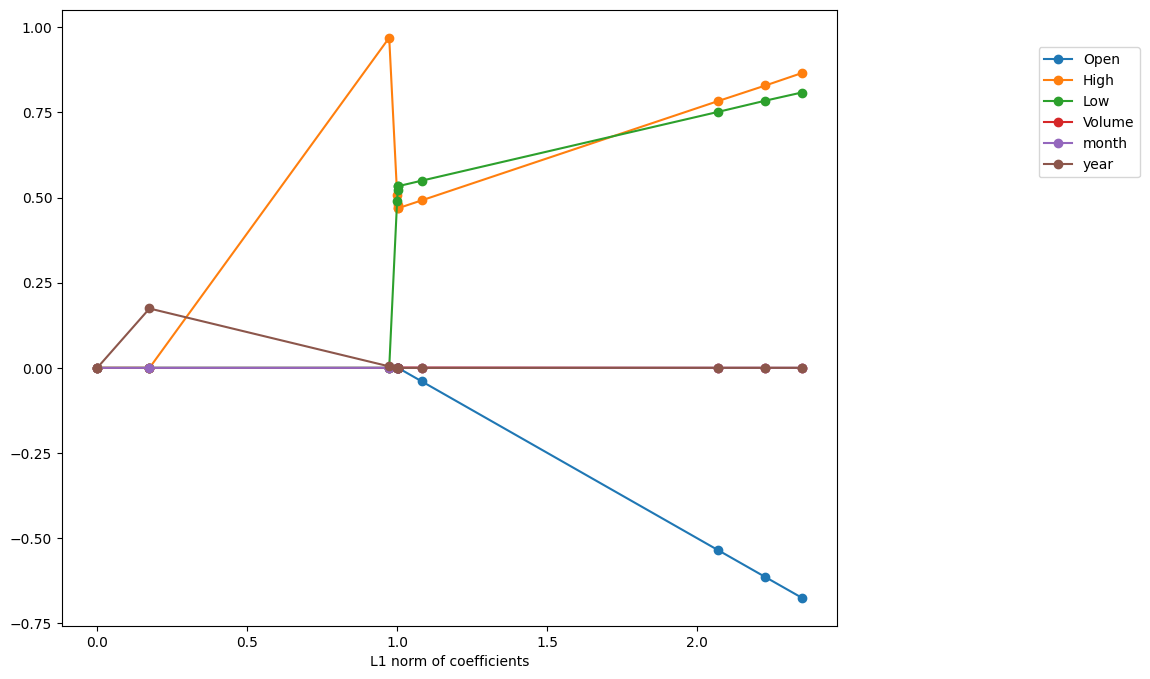

In [ ]:
# dataframes need to be converted to numpy format
XX = X_train.to_numpy()
yy = y_train.to_numpy()
_, _, coefs = linear_model.lars_path(XX, yy, method="lasso")

# plot the corresponding result
tau = np.sum(np.abs(coefs.T), axis=1)
plt.figure(figsize=(10, 8))
plt.xlabel("L1 norm of coefficients")
plt.plot(tau, coefs.T, marker="o")
plt.legend(list(X_train.columns), bbox_to_anchor=(1.4, 0.95))
plt.show()

In the LARS (Least Angle Regression) path plot, all coefficients, including those that are eventually set to zero, are visualized as the algorithm progresses through the regularization path. This allows you to see how each coefficient evolves with increasing regularization strength. Therefore, even though the "Open" coefficient may eventually be set to zero by Lasso regularization, it still appears in the LARS path plot until it reaches zero.

We can notice that the first feature to be non-zero here is the year possibly since towards the end, we can see a huge spike in adjusted close prices after the year 2020. However, 'High' seems to be the feature with the most relevance as it is the first to be non-zero when decreasing the penalty(starting from a large value).

###Ridge Regression

In [ ]:
al = 0.001

X1 = df_train[['High','Open','Low','Volume','year','month']]
y1 = df_train['Adj Close']
X2 = df_test[['High','Open','Low','Volume','year','month']]
y2 = df_test['Adj Close']

st = time.time()
ridge = Ridge(alpha=al,max_iter=10000)
ridge.fit(X1, y1)
et=time.time()
print("Time to fit: ",(et-st),"s")

# Report coefficients
print('Intercept:', ridge.intercept_)
print('Rounded coef:', list(map(lambda c: round(c, 3), ridge.coef_)))
print('\nR2  (train) = ',ridge.score(X1,y1))
y_pred_train = ridge.predict(X2)

MSE = mean_squared_error(y2, y_pred_train)
print('MSE (train) = ',MSE)

Time to fit:  0.025516510009765625 s
Intercept: -0.0002221317227329711
Rounded coef: [0.846, -0.639, 0.791, -0.001, 0.0, 0.0]

R2  (train) =  0.9997525577536818
MSE (train) =  1.3076724675046853e-05


Here using an arbitrary regularizator value gives us a better result in terms of score and $MSE$.

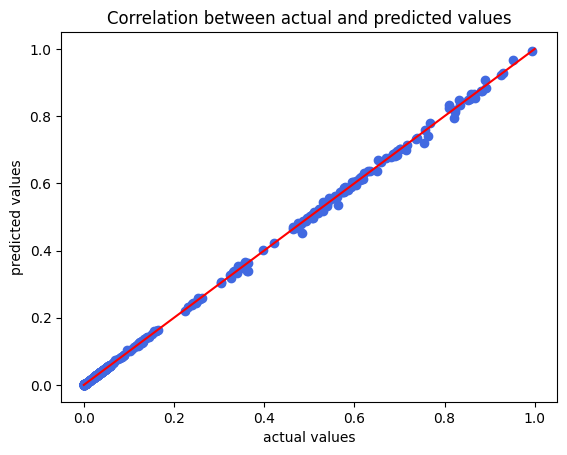

In [ ]:
# plotting the results
plt.title('Correlation between actual and predicted values')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.scatter(y2,y_pred_train,color='royalblue')
plt.plot([0,1],[0,1],color='red')
plt.show()

We calculate the average $MSE$ and $R^{2}$ score over various test train splits

In [ ]:
al = 0.01
nb_real = 100

R2_test = np.zeros(nb_real)
MSE_test = np.zeros(nb_real)

ridge = Ridge(alpha = al,max_iter=10000)
for real in range(nb_real):
  df_train1, df_test1 = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
  df_train1[:] = scaler.fit_transform(df_train1[:])
  X_train = df_train1[['Open','High','Low','Volume','year','month']]
  y_train = df_train1['Adj Close']
  ridge.fit(X_train, y_train)
  df_test1[:] = scaler.transform(df_test1[:])
  X_test = df_test1[['Open','High','Low','Volume','year','month']]
  y_test = df_test1['Adj Close']
  R2_test[real] = ridge.score(X_test,y_test)
  MSE_test[real] = mean_squared_error(y_test, ridge.predict(X_test))

print('Average R2  (test) =', R2_test.mean())
print('Average MSE (test) =', MSE_test.mean())

Average R2  (test) = 0.9996916354915913
Average MSE (test) = 1.2935642270381253e-05


Next, we perform some cross validation on the  α  values to check for the best regularizator value. We also proceed to note the coefficients related to each feature, indicating the feature importance according to Ridge regression.

In [ ]:
df_train2, df_test2 = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train2[:] = scaler.fit_transform(df_train2[:])
X_train = df_train2[['Open','High','Low','Volume','year','month']]
y_train = df_train2['Adj Close']

alphas_ridge = np.logspace(-7, -3, 500)
reg = RidgeCV(cv=None, alphas = alphas_ridge, scoring=None, store_cv_values=True)
st = time.time()
reg.fit(X_train, y_train)
et=time.time()
print("Time to fit: ",(et-st),"s")
print('Regularizator score (R2 coefficient):', reg.score(X_train, y_train))
y_train_pred = reg.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
print('Mean Squared Error (MSE):', mse_train)
print('Regularizator\'s optimal alpha value:', reg.alpha_)
print('Regularizator coefficients:')
[(pair[0], round(pair[1], 4)) for pair in zip(X_train.columns, reg.coef_)]

Time to fit:  0.270951509475708 s
Regularizator score (R2 coefficient): 0.9997504761940109
Mean Squared Error (MSE): 1.0448937492796454e-05
Regularizator's optimal alpha value: 2.1911966875781472e-05
Regularizator coefficients:


[('Open', -0.716),
 ('High', 0.9759),
 ('Low', 0.7377),
 ('Volume', -0.0006),
 ('year', 0.0001),
 ('month', 0.0004)]

**Observations:**

**1)**The Ridge regression model demonstrates a high level of predictive accuracy, as indicated by the R2 coefficient of 0.9997.

**2)**The optimal alpha value, chosen to balance between model complexity and performance, is 1e-07. Thus indicating that very little regularization is required.

**3)**Notably, the coefficients for 'Open', 'High', and 'Low' exhibit strong correlations with the target variable 'Adj Close', as evidenced by their magnitudes and signs.

**4)**'Volume' does not contribute significantly to the model, as its coefficient is effectively reduced to zero due to Lasso's regularization effect.
The coefficients for 'year' is 0 and 'month' is minimal, suggesting limited influence on the target variable compared to the price-related features.

We plot the graph of the mean squared error values versus the  $\alpha$  values

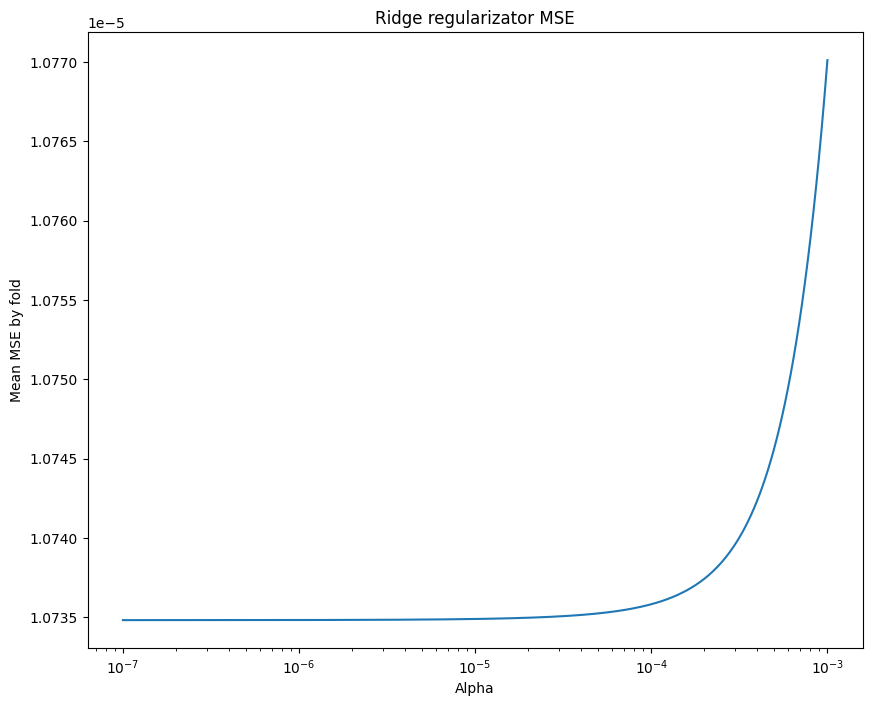

In [ ]:
mean_mse_arr = np.array(reg.cv_values_).mean(axis=0)
plt.figure(figsize=(10, 8))
plt.semilogx(alphas_ridge, mean_mse_arr, label=feature )
plt.xlabel("Alpha")
plt.ylabel("Mean MSE by fold")
plt.title("Ridge regularizator MSE")
plt.show()

There seems to be an increase in the MSE with increase in alpha values, indicating that there is very little regularization that is required.

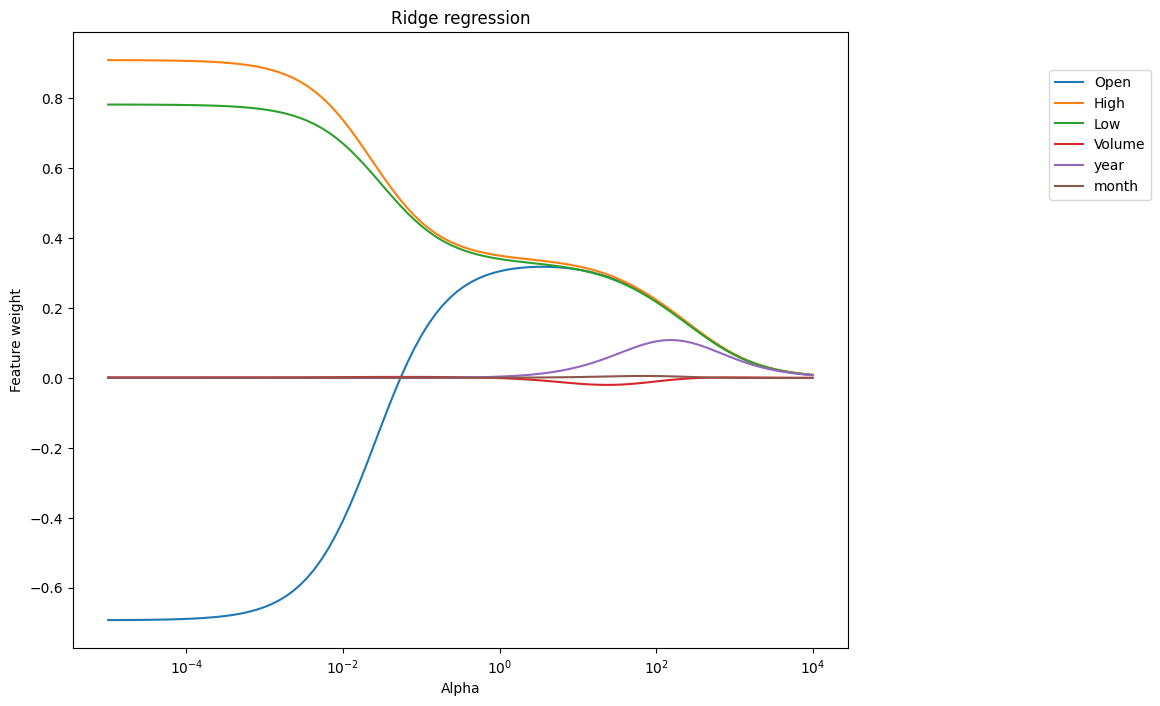

In [ ]:
alphas_ridge = np.logspace(-5, 4, 100)
coefs_ridge = np.zeros((alphas_ridge.shape[0], X_train.shape[1]))

for i, al in enumerate(alphas_ridge):
    ridge = Ridge(alpha = al)
    ridge.fit(X_train, y_train)
    for j, coef in enumerate(ridge.coef_):
        coefs_ridge[i][j] = coef

plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_ridge.T, X_train.columns):
    plt.semilogx(alphas_ridge, coef, label=feature)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("Alpha")
plt.ylabel("Feature weight")
plt.title("Ridge regression")
plt.show()

From this plot, it is evident that 'High' has the largest coefficient indicating having the largest influence in predicting the adjusted close prices, followed by 'Low' and 'Open'.

##TREES

###Decision Trees

We start by performing regression with a single tree.

The key parameters to avoid overfitting are
- *max_depth* to limit the maximal depth of the tree
- *min_samples_leaf* to ask for a minimal number of data points for a condition to be satisfied
We start by playing around with a few values of these parameters to get a feeling of what is done/obtained.

Time to fit:  0.013967514038085938 s
MSE (test): 4.971193035657127e-05
R2  (test): 0.9987781095152884


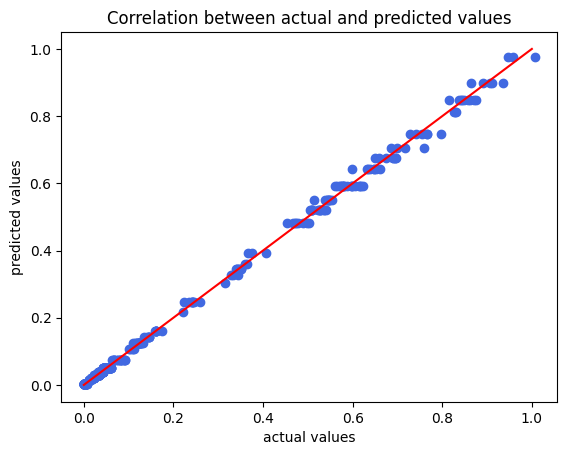

In [ ]:
# choice of parameters
chosen_max_depth = 5
chosen_min_samples_leaf = 4

# constructing + fitting the model and making the prediction
st = time.time()
dt = DecisionTreeRegressor(max_depth=chosen_max_depth, min_samples_leaf=chosen_min_samples_leaf)
model = dt.fit(X_train,y_train)
et=time.time()
print("Time to fit: ",(et-st),"s")
y_pred = model.predict(X_test)

# computing the performance on the test set
# MSE between prediction and true values
mse = mean_squared_error(y_pred,y_test)
print('MSE (test):',mse)
# coefficient of determination for the regression
R2 = dt.score(X_test,y_test)
print('R2  (test):',R2)
# plotting predicted values as a function of true values to graphically assess the quality of regression
plt.title('Correlation between actual and predicted values')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.scatter(y_test,y_pred,color='royalblue')
plt.plot([0,1],[0,1],color='red')
plt.show()

The plot depicting the correlation between actual and predicted values shows a strong linear relationship, with predicted values closely aligning with the diagonal line representing perfect prediction. Overall, the performance of the Decision Tree Regression model appears to be comparable to that of a simple linear regression model.

We can visualize the tree using the function plot_tree

The performance seems to be comparable to that of simple linear regression

Number of data points :  2069
X[ 0 ] =  Open
X[ 1 ] =  High
X[ 2 ] =  Low
X[ 3 ] =  Adj Close
X[ 4 ] =  Volume
X[ 5 ] =  year
X[ 6 ] =  month


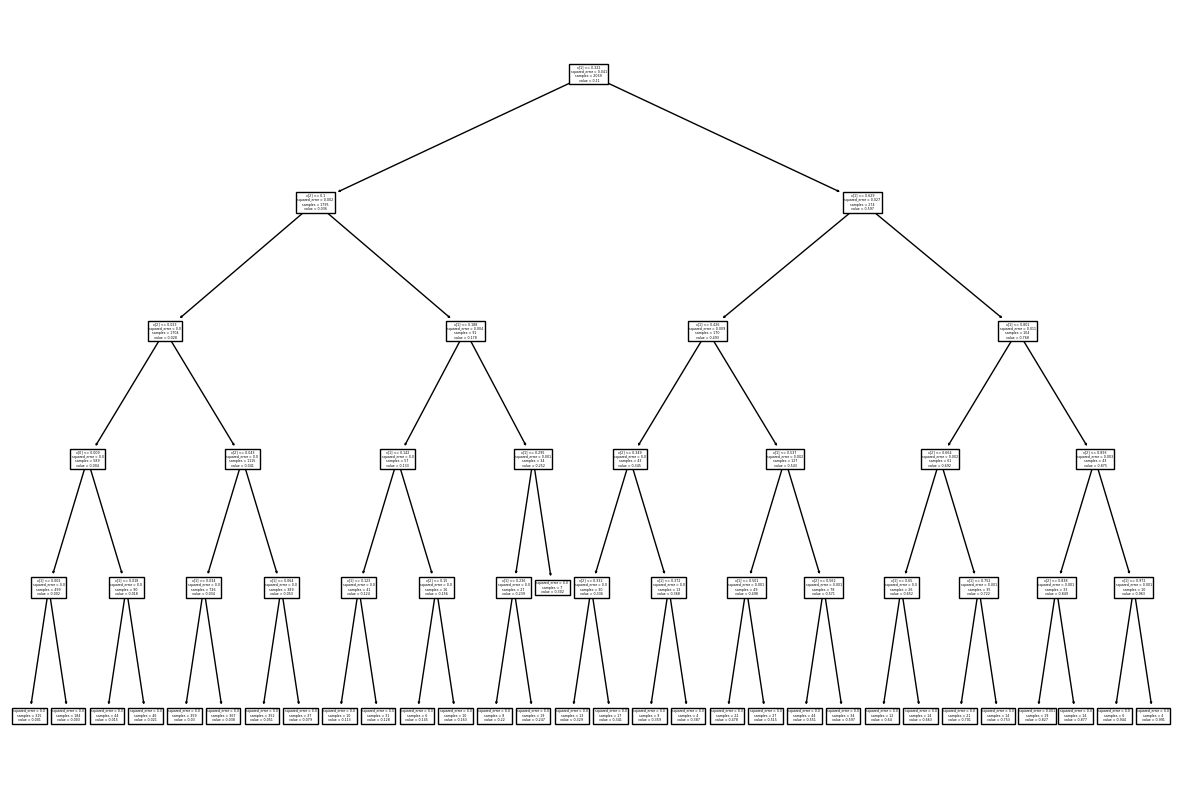

In [ ]:
print('Number of data points : ',y_train.shape[0])
for pair in zip(df_train.columns, np.arange(df_train.shape[0])):
  print('X[',pair[1],'] = ', pair[0])
plt.figure(figsize=(15, 10))
tree.plot_tree(dt)
plt.show()

We next explore more systematically the choice of the parameters by cross validation using GridSearchCV

In [ ]:
dt = DecisionTreeRegressor()
dt_params = {'max_depth':np.arange(1,20),'min_samples_leaf':np.arange(1,20)}

In [ ]:
# the output (best parameters) is in the 'dict' format = dictionary
print('Grid search to find optimal parameters')
st = time.time()
gs_dt = GridSearchCV(estimator=dt, param_grid=dt_params)
gs_dt.fit(X_train,y_train)
et=time.time()
print("Time to fit: ",(et-st),"s")
a = gs_dt.best_params_
print('- Best maximal depth =',a['max_depth'])
print('- Best minimal number of samples in the leaves = ',a['min_samples_leaf'],'\n')

Grid search to find optimal parameters
Time to fit:  29.127022743225098 s
- Best maximal depth = 11
- Best minimal number of samples in the leaves =  3 



Time to fit:  0.01434636116027832 s
MSE (test): 2.2297482161187184e-05
R2  (test): 0.9994518035792916


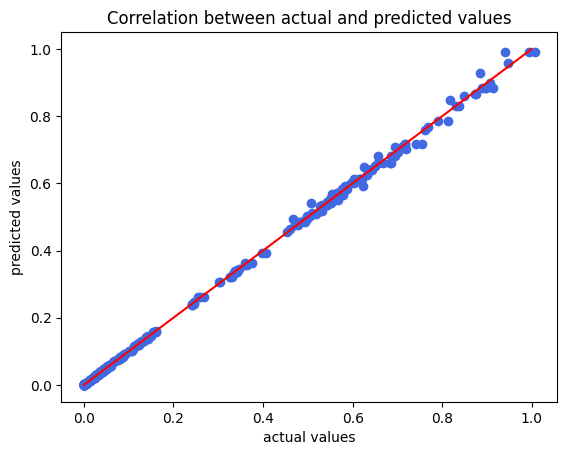

In [ ]:
# training with best parameters
st = time.time()
dt_final = DecisionTreeRegressor(max_depth=a['max_depth'], min_samples_leaf=a['min_samples_leaf'])
model = dt_final.fit(X_train,y_train)
et=time.time()
print("Time to fit: ",(et-st),"s")
y_pred = model.predict(X_test)

# computing the performance on the test set
# MSE between prediction and true values
mse = mean_squared_error(y_pred,y_test)
print('MSE (test):',mse)
# coefficient of determination for the regression
R2 = dt_final.score(X_test,y_test)
print('R2  (test):',R2)
# plotting predicted values as a function of true values to graphically assess the quality of regression
plt.title('Correlation between actual and predicted values')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.scatter(y_test,y_pred,color='royalblue')
plt.plot([0,1],[0,1],color='red')
plt.show()

We can see a decrease in the $MSE$ and a higher $R^2$ score. Prediction wise it seems to be comparable to Lasso regression. However, we use trees for better interpretability of the data. If the data were to be non-linear, using trees would have displayed better results.

###Random Forests

We will use random forests by combining trees and see if there is any difference in results.

In [ ]:
rf = RandomForestRegressor()

In [ ]:
rf_params = {'n_estimators':np.arange(25,150,25),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}
print('Grid search to find optimal parameters')
st = time.time()
gs_rf = GridSearchCV(estimator=rf,param_grid=rf_params)
gs_rf.fit(X_train,y_train)
et=time.time()
print("Time to fit: ",(et-st),"s")
b = gs_rf.best_params_
print('- Best number of trees = ',b['n_estimators'])
print('- Best maximal depth =',b['max_depth'])
print('- Best minimal number of samples in the leaves = ',b['min_samples_leaf'],'\n')

Grid search to find optimal parameters
Time to fit:  205.48595237731934 s
- Best number of trees =  125
- Best maximal depth = 9
- Best minimal number of samples in the leaves =  2 



In [ ]:
# fitting the model with best params
RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'])
st = time.time()
model = RF.fit(X_train,y_train)
et=time.time()
print("Time to fit: ",(et-st),"s")
y_pred = model.predict(X_test)

Time to fit:  0.8927288055419922 s


R2  (test): 0.999595761774757
MSE (test): 1.6442089506129243e-05


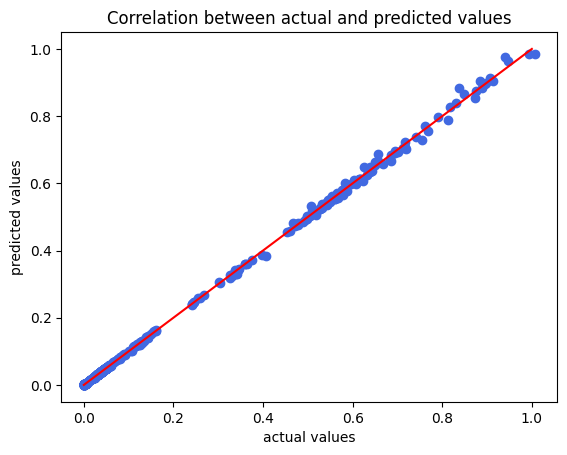

In [ ]:
# compute the performance on the test set
R2 = RF.score(X_test,y_test)
print('R2  (test):',R2)
mse = mean_squared_error(y_pred,y_test)
print('MSE (test):',mse)
plt.title('Correlation between actual and predicted values')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.scatter(y_test,y_pred,color='royalblue')
plt.plot([0,1],[0,1],color='red')
plt.show()

We can see an improvement in performance with scores being comparable to Ridge regression.

###AdaBoost

Next we try and see if there is any change in performance with AdaBoost.

In [ ]:
ar = AdaBoostRegressor(estimator = dt_final)

In [ ]:
print('Tree maximal depth (weak learner) =',dt_final.max_depth)
print('Minimal number of samples in the leaves (weak learner) = ',dt_final.min_samples_leaf,'\n')
# key parameter: number of weak learners to be considered
print('Grid search to find optimal parameters')
ar_params = {'n_estimators':np.arange(10,200,10)}
st = time.time()
gs_ar = GridSearchCV(estimator=ar,param_grid=ar_params)
gs_ar.fit(X_train,y_train)
et=time.time()
print("Time to fit: ",(et-st),"s")
c = gs_ar.best_params_
print('- Best number of weak learners (trees) = ',c['n_estimators'],'\n')

Tree maximal depth (weak learner) = 11
Minimal number of samples in the leaves (weak learner) =  3 

Grid search to find optimal parameters
Time to fit:  51.84509992599487 s
- Best number of weak learners (trees) =  10 



In [ ]:
# Fitting the model with best params
st = time.time()
ab_dt = AdaBoostRegressor(n_estimators=50)
model = ab_dt.fit(X_train,y_train)
et=time.time()
print("Time to fit: ",(et-st),"s")
y_pred = model.predict(X_test)

Time to fit:  0.19281601905822754 s


R2  (test): 0.99414564905219
MSE (test): 0.00023812137564752878


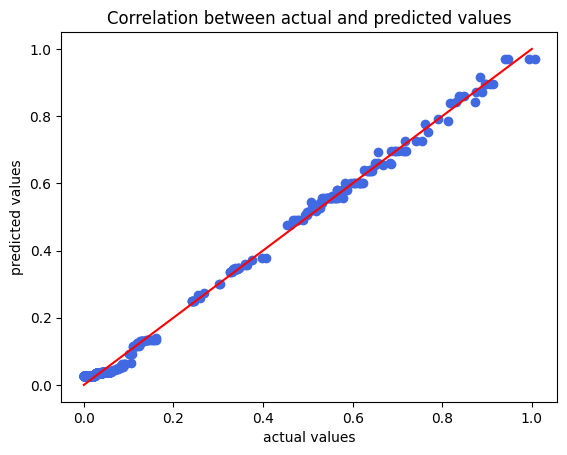

In [ ]:
# computing the performance on the test set
R2 = ab_dt.score(X_test,y_test)
print('R2  (test):',R2)
mse = mean_squared_error(y_pred,y_test)
print('MSE (test):',mse)
plt.title('Correlation between actual and predicted values')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.scatter(y_test,y_pred,color='royalblue')
plt.plot([0,1],[0,1],color='red')
plt.show()

The performance is significantly weaker in this case, as compared to all other models that were used before. This is because of multicollinearity. AdaBoost's performance can be influenced by correlated features, especially if they dominate the feature importance in the ensemble.

###XGBoost

In [ ]:
xgboost = XGBRegressor()

In [ ]:
print('Tree maximal depth (weak learner) =', dt_final.max_depth)
print('Minimal number of samples in the leaves (weak learner) = ', dt_final.min_samples_leaf, '\n')

print('Grid search to find optimal parameters')
xgboost_params = {'n_estimators': range(10, 200, 10)}
st = time.time()
gs_xgboost = GridSearchCV(estimator=xgboost, param_grid=xgboost_params)
gs_xgboost.fit(X_train, y_train)
et=time.time()
print("Time to fit: ",(et-st),"s")
d = gs_xgboost.best_params_
print('- Best number of weak learners (trees) = ', d['n_estimators'], '\n')

Tree maximal depth (weak learner) = 11
Minimal number of samples in the leaves (weak learner) =  3 

Grid search to find optimal parameters
Time to fit:  8.13218879699707 s
- Best number of weak learners (trees) =  70 



In [ ]:
# Fitting the model with best params
st = time.time()
xg_dt = XGBRegressor(n_estimators=30)
model = xg_dt.fit(X_train,y_train)
et=time.time()
print("Time to fit: ",(et-st),"s")
y_pred = model.predict(X_test)

Time to fit:  0.06083536148071289 s


R2  (test): 0.99414564905219
MSE (test): 3.1540621704796374e-05


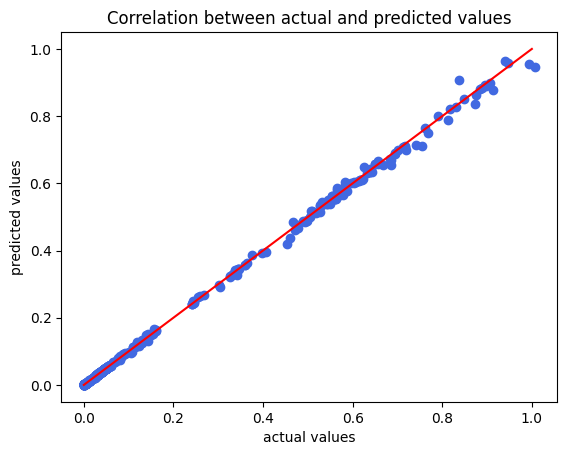

In [ ]:
# computing the performance on the test set
R2 = ab_dt.score(X_test,y_test)
print('R2  (test):',R2)
mse = mean_squared_error(y_pred,y_test)
print('MSE (test):',mse)
plt.title('Correlation between actual and predicted values')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.scatter(y_test,y_pred,color='royalblue')
plt.plot([0,1],[0,1],color='red')
plt.show()

Although the $MSE$ is quite low compared to the AdaBoost, the $R^{2}$ is comparable.

<Figure size 1000x800 with 0 Axes>

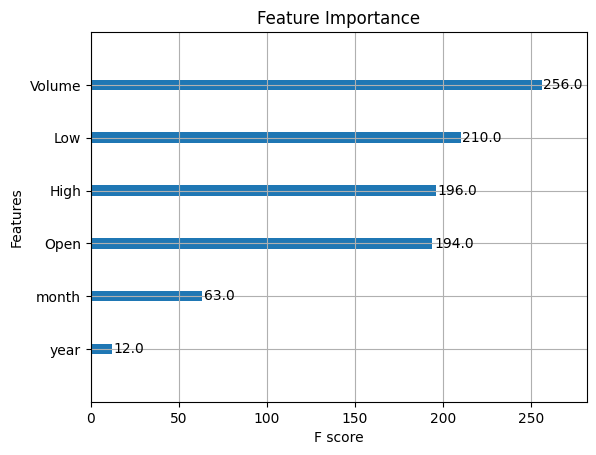

In [ ]:
plt.figure(figsize=(10, 8))
plot_importance(xg_dt, max_num_features=6)
plt.title("Feature Importance")
plt.show()

From this it seems that XGBoost migh be using the volume feature to split the data at the root node. This is probably because that feature is the only one where the values are not correlated, other than month or year.

## LSTM

**Long Short-Term Memory (LSTM)** is a type of recurrent neural network (RNN) architecture designed to address the vanishing gradient problem in traditional RNNs. It is well-suited for sequence prediction tasks, such as time series forecasting, natural language processing, and speech recognition. LSTMs have memory cells that can maintain information over long sequences, allowing them to capture dependencies and patterns in sequential data more effectively. They achieve this by using gated units, including input, forget, and output gates, which regulate the flow of information through the network, enabling it to learn long-term dependencies and handle sequences of varying lengths. This makes LSTMs particularly powerful for modeling and predicting time-dependent data where context and temporal dynamics are essential.

We derive the columns based on which we would like to train the model and the target feature (Adj Close) that we want to predict.

In [ ]:
X_ = df[['Open','High','Low','Volume','year','month']]
y_ = df[['Adj Close']]

In [ ]:
#We scale the data in the range (0,1)
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.2)

sc = MinMaxScaler((0,1))

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

y_train = sc.fit_transform(y_train)
y_test = sc.transform(y_test)

We define the model next.

In [ ]:
model_LSTM = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model_LSTM.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1),activation='tanh'))#input layer
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(50, return_sequences = True, activation='tanh'))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(50, return_sequences = True, activation='tanh'))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(50, activation='tanh'))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(Dense(25))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(Dense(1)) #output layer

model_LSTM.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])

**A few terms that were used above:**

**1.** `return_sequences=True` argument indicates that this layer will return sequences instead of a single output

**2.** `model_LSTM.add(Dropout(0.2))` Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of input units(neurons) to 0 during training to reduce co-dependency between neurons. Here, a dropout layer with a dropout rate of 0.2 (20%) is added after each LSTM layer.

**3.** The `activation='tanh'` argument specifies the activation function to be used, in this case, the hyperbolic tangent function.

**4.** `model_LSTM.add(Dense(1))` declares a dense layer with a single unit is added as the output layer. This layer will output a single numerical value, making it suitable for regression tasks.

We run the model with some parameters to test its performance.

In [ ]:
st = time.time()
History = model_LSTM.fit(X_train, y_train, epochs = 100, batch_size = 32)
et=time.time()
print("Time to fit: ",(et-st),"s")

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0277 - mean_squared_error: 0.0277
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 11/100
74/74 ━━━━━━━━━━━━━━━━━━━━

Next we plot the $MSE$ over epochs

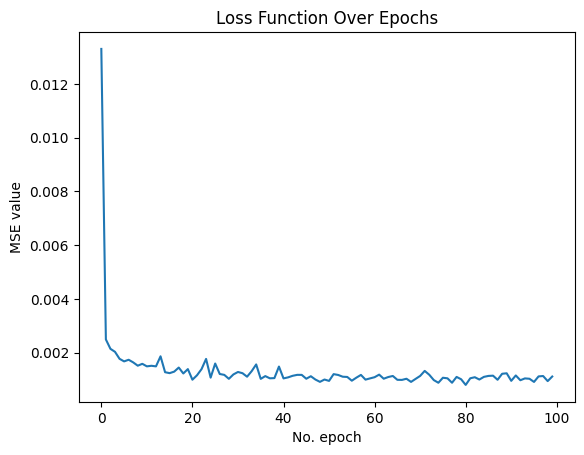

In [ ]:
plt.plot(History.history['mean_squared_error'])
plt.title('Loss Function Over Epochs')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.show()

It seems to be quite clear that as the number of epochs increase, the $MSE$ seems to decreases significantly, initially, after which it almost stabilizes, having a general downward like trend.

Next we perform some predictions on the test data

In [ ]:
y_pred = model_LSTM.predict(X_test)
y_pred_copy = np.repeat(y_pred,7, axis=-1)
y_test_copy = np.repeat(y_test,7, axis=-1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


I perform `scaler.inverse_transform ` because I want a comparison between what the predicted values were and what are the actual values. This will help me get the values in there original unscaled form.

In [ ]:
y_predInverse = scaler.inverse_transform(np.reshape(y_pred_copy,(len(y_test),7)))[:,0]
y_testInverse = scaler.inverse_transform(np.reshape(y_test_copy,(len(y_test),7)))[:,0]

In [ ]:
# Create a dataframe for predicted and original values
pred_df = pd.DataFrame({'Predicted Values': y_predInverse.flatten(), 'Original Values': y_testInverse.flatten()})
print(pred_df)

     Predicted Values  Original Values
0           68.328400        66.847353
1           19.288319         3.880165
2           55.084156        48.960818
3           65.142883        58.928783
4          845.245117       879.569688
..                ...              ...
587         50.752186        33.924569
588         56.651749        46.166737
589         23.937826         5.405670
590         71.360580        71.164933
591         47.778675        38.398712

[592 rows x 2 columns]


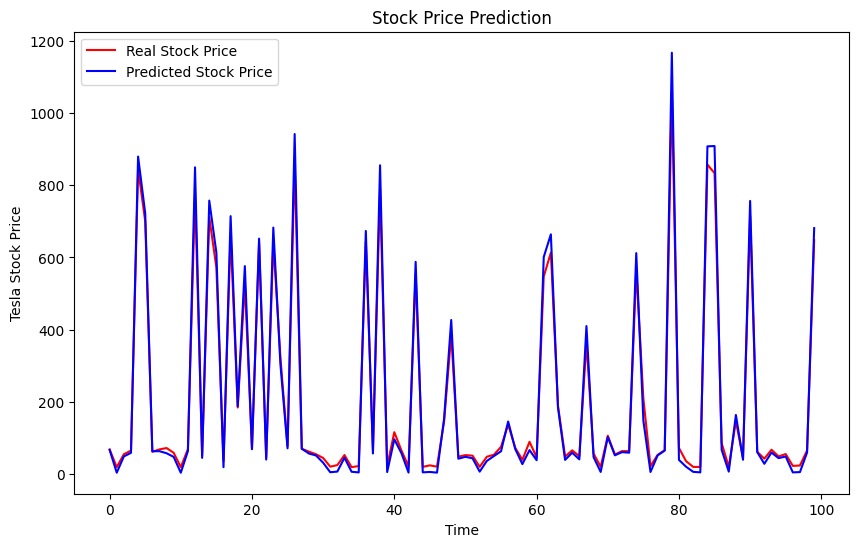

In [ ]:
# Plot the data
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.plot(y_predInverse[:100], color='red', label='Real Stock Price')  # Plot first 100 data points of y_pred_inverse
plt.plot(y_testInverse[:100], color='blue', label='Predicted Stock Price')  # Plot first 100 data points of y_test_inverse
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

**1. Root Mean Squared Error (RMSE):** RMSE is a measure of the differences between values predicted by a model and the observed values. It is calculated by taking the square root of the average of the squared differences between the predicted and observed values. RMSE provides a measure of the spread of the residuals (the differences between predicted and observed values), with lower values indicating better fit.

**2. Mean Absolute Percentage Error (MAPE):** MAPE is a measure of the accuracy of a forecasting method in statistics. It is calculated as the average of the absolute percentage differences between the predicted and observed values, divided by the observed values. MAPE provides a measure of the accuracy of the predictions as a percentage of the true values, with lower values indicating better accuracy.

In [ ]:
# Calculate RMSE
rmse = np.sqrt(np.mean(((y_pred - y_test) ** 2)))
print('Root Mean Squared Error:', rmse)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test))

print('Mean Absolute Percentage Error (MAPE):', mape)

Root Mean Squared Error: 0.018877908246152052
Mean Absolute Percentage Error (MAPE): 2.90002379176127


Now to find the best parameters for the model, we perform grid search cross validation.


In [ ]:
def buildModel(optimizer='Adam'):
    model_LSTM = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    model_LSTM.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1),activation='tanh'))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(LSTM(50, return_sequences = True, activation='tanh'))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(LSTM(50, return_sequences = True, activation='tanh'))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(LSTM(50, activation='tanh'))
    model_LSTM.add(Dropout(0.2))

    model_LSTM.add(Dense(25))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(1))

    model_LSTM.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])

    return model_LSTM

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Create the KerasRegressor with the early stopping callback
model_LSTM = KerasRegressor(model=buildModel,callbacks=[early_stopping])

# Define the hyperparameter grid
param_grid = {
    'optimizer': ['SGD', 'Adagrad', 'Adam'],
    'batch_size': [20, 60, 100,150],
    'epochs': [10, 50, 100]
}
grid = GridSearchCV(estimator=model_LSTM, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X_train, y_train)


exe_time_nn = time.time() - start_time
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Time taken for execution :", exe_time_nn)


c:\Users\kanup\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\kanup\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0368 - mean_squared_error: 0.0368
Epoch 2/100
 9/40 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041

c:\Users\kanup\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error
  current = self.get_monitor_value(logs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - mean_squared_error: 0.0011     
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21

We fit the model using the best paramters derived from performing the gris search cross validation.

In [ ]:
st = time.time()
best = model_LSTM.fit(X_train, y_train, epochs = 100, batch_size = 60)
et=time.time()
print("Time to fit: ",(et-st),"s")

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 0.0321 - mean_squared_error: 0.0321
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━

We plot the $MSE$ over the epochs next for the best paramater model.

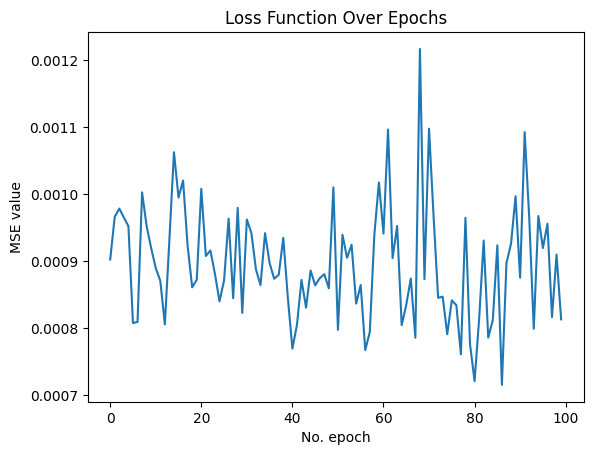

In [ ]:
plt.plot(best.history['mean_squared_error'])
plt.title('Loss Function Over Epochs')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.show()

There seems to be a significant drop in the maximum value of the $MSE$, being significantly less than the $MSE$ that was seen previously. However, it seems to be more or less stagnant over the number of epochs, indicating that there is not much change that is achieved in the predictions with change in epochs.

In [ ]:
y_pred_best = model_LSTM.predict(X_test)
y_predbest_copy = np.repeat(y_pred_best,7, axis=-1)
y_testbest_copy = np.repeat(y_test,7, axis=-1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


In [ ]:
y_predbestInverse = scaler.inverse_transform(np.reshape(y_predbest_copy,(len(y_test),7)))[:,0]
y_testbestInverse = scaler.inverse_transform(np.reshape(y_testbest_copy,(len(y_test),7)))[:,0]

In [ ]:
# Create a dataframe for predicted and original values
pred_dfbest = pd.DataFrame({'Predicted Values': y_predbestInverse.flatten(), 'Original Values': y_testbestInverse.flatten()})
print(pred_dfbest)

     Predicted Values  Original Values
0           41.260933        40.040132
1            7.234919         6.867734
2           81.887047        76.923494
3           55.482330        56.829351
4          663.806396       649.878129
..                ...              ...
587         64.592873        54.057746
588         13.626299         7.320241
589         52.479053        52.411347
590         72.956497        72.689320
591        624.235107       568.689484

[592 rows x 2 columns]


The values seem to be a lot closer than the one from the previous model, thus indicating significant improvement in predictions after performing grid search cross validation.

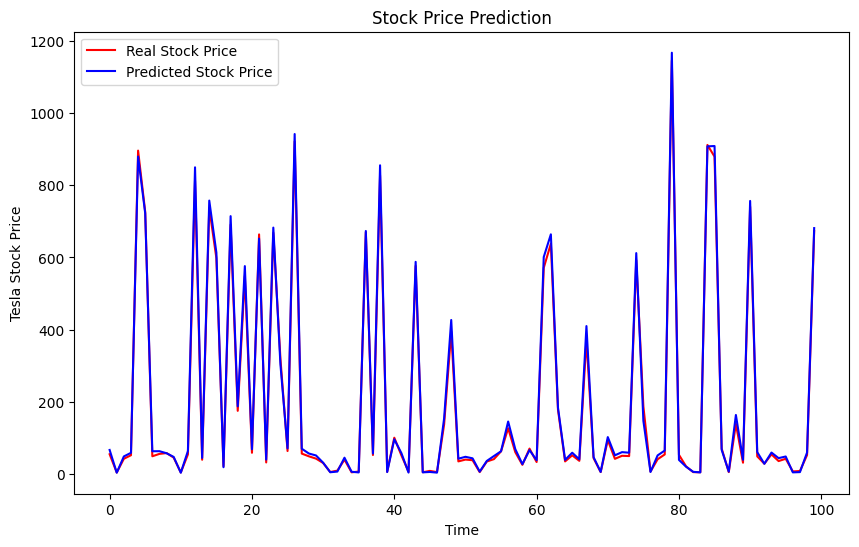

In [ ]:
# Plot the data
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.plot(y_predbestInverse[:100], color='red', label='Real Stock Price')  # Plot first 100 data points of y_pred_inverse
plt.plot(y_testbestInverse[:100], color='blue', label='Predicted Stock Price')  # Plot first 100 data points of y_test_inverse
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

The predicted and actual values seem to be a lot closer as compared to before.

In [ ]:
# Calculate RMSE
rmse = np.sqrt(np.mean(((y_pred_best - y_test) ** 2)))
print('Root Mean Squared Error:', rmse)

# Calculate MSE
mse = np.mean(((y_pred_best - y_test) ** 2))
print('Mean Squared Error:', mse)

# Calculate MAPE
mape = np.mean(np.abs((y_test - y_pred_best) / y_test))
print('Mean Absolute Percentage Error (MAPE):', mape)

#Calculate R^2 score
r2 = r2_score(y_test, y_pred_best)
print('Coefficient of determination (R^2):', r2)

Root Mean Squared Error: 0.01014809079710912
Mean Squared Error: 0.0001029837468263708
Mean Absolute Percentage Error (MAPE): 0.6733656674319204
Coefficient of determination (R^2): 0.9972525842877972


There is a drop noticed in both the `rmse` and the `mape` values after implementing the best parameters for training the model.

## COMPARISON BETWEEN MODELS

In [ ]:
models_performance = {
    "Linear Regression": {
        "MSE": 3.18e-5,
        "R2": 0.99929,
        "Time": 0.00499
    },
    "Ridge Regression": {
        "MSE": 1.044e-5,
        "R2": 0.9997,
        "Time": 0.27
    },
    "Lasso": {
        "MSE": 1.05e-5,
        "R2": 0.9997,
        "Time": 1.18
    },
    "Decision Tree": {
        "MSE": 2.2e-5,
        "R2": 0.9994,
        "Time": 29.13
    },
    "Random Forest": {
        "MSE": 1.64e-5,
        "R2": 0.9995,
        "Time": 204.37
    },
    "Adaboost": {
        "MSE": 0.00523,
        "R2": 0.9941,
        "Time": 52.74
    },
    "Xgboost": {
        "MSE": 3.15e-5,
        "R2": 0.9941,
        "Time": 8.19
    },
    "LSTM": {
        "MSE": 0.00010,
        "R2": 0.9972,
        "Time": 4357.9

    }
}


We display in the form of a dataframe.

In [ ]:
df_comparison = pd.DataFrame(models_performance).T
print(df_comparison)

                        MSE       R2        Time
Linear Regression  0.000032  0.99929     0.00499
Ridge Regression   0.000010  0.99970     0.27000
Lasso              0.000010  0.99970     1.18000
Decision Tree      0.000022  0.99940    29.13000
Random Forest      0.000016  0.99950   204.37000
Adaboost           0.005230  0.99410    52.74000
Xgboost            0.000031  0.99410     8.19000
LSTM               0.000100  0.99720  4357.90000


In [ ]:
execution_times = []
mse_values = []
r2_values = []
accuracy_values = []

for model, metrics in models_performance.items():
    execution_times.append(metrics["Time"])
    mse_values.append(metrics["MSE"])
    r2_values.append(metrics["R2"])
    accuracy_values.append(metrics["R2"])


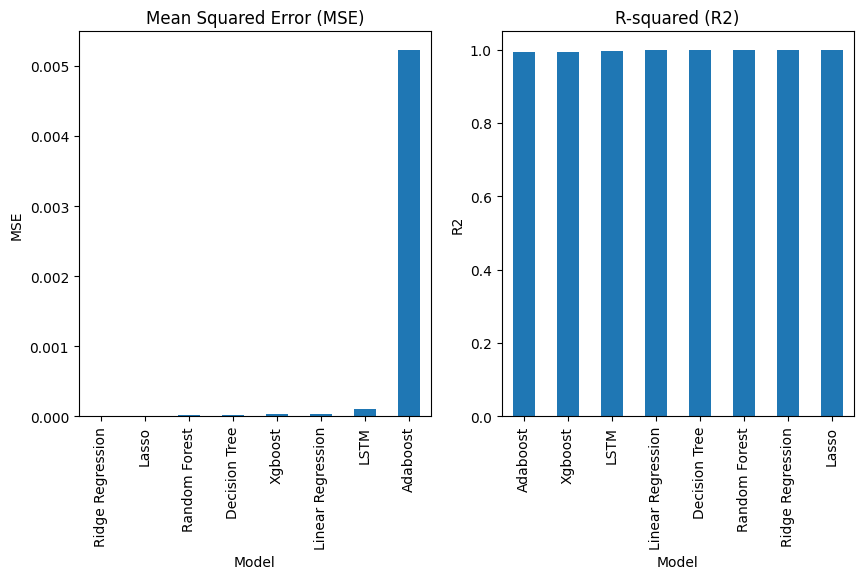

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

df_comparison['MSE'].sort_values().plot(kind='bar', ax=axes[0])
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('MSE')

df_comparison['R2'].sort_values().plot(kind='bar', ax=axes[1])
axes[1].set_title('R-squared (R2)')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('R2')



plt.show()

Text(0, 0.5, 'Time')

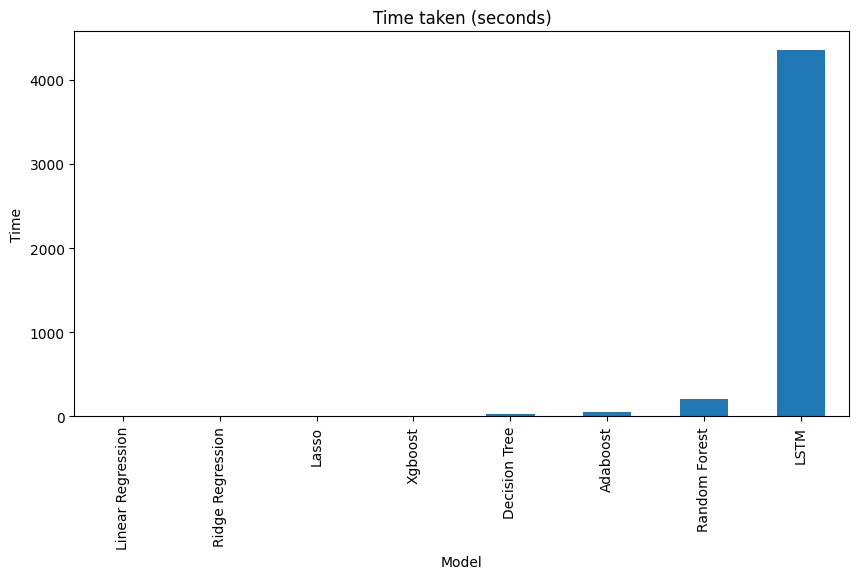

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

df_comparison['Time'].sort_values().plot(kind='bar', ax=axes)
axes.set_title('Time taken (seconds)')
axes.set_xlabel('Model')
axes.set_ylabel('Time')

**Based on the comparison of different models:**

**1. MSE (Mean Squared Error):** Lower values indicate better performance in terms of minimizing prediction errors. Among the models, Ridge Regression, Lasso, and Random Forest have relatively lower MSE values, suggesting better predictive accuracy.

**2. R2 (Coefficient of Determination):** Higher values indicate better goodness of fit. Ridge Regression, Lasso, and Random Forest exhibit higher R2 values, indicating a better fit to the data compared to other models.

**3.Time Taken: **LSTM, while providing reasonable predictive performance, requires significantly more computational time compared to other models. Linear Regression and Ridge Regression are the fastest in terms of computation time.


In conclusion, considering both predictive accuracy and computational efficiency, Ridge Regression and Lasso stand out as the top-performing models, followed closely by Random Forest. However, if computational time is not a constraint and higher complexity models are taken into consideration, LSTM may provide competitive performance.

## REFERENCES

**Datatset:**

TESLA Stock Data. (2022, March 25). Kaggle. https://www.kaggle.com/datasets/varpit94/tesla-stock-data-updated-till-28jun2021/code

**Notebooks and articles referred:**

Sksujanislam. (2023, October 13). MULTIVARIATE TIME SERIES FORECASTING USING LSTM - Sksujanislam - Medium. Medium. https://medium.com/@786sksujanislam786/multivariate-time-series-forecasting-using-lstm-4f8a9d32a509

Zahraaalaatageldein. (2024, January 29). 🥏Deep Analysis with NNs [ups&downs]. https://www.kaggle.com/code/zahraaalaatageldein/deep-analysis-with-nns-ups-downs

Omarrezk. (2023, October 26). Tesla Stock EDA & Prediction. https://www.kaggle.com/code/omarrezk/tesla-stock-eda-prediction